In [1]:
import os
import numpy as np
import keras
import math
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from kapre.utils import Normalization2D
#from kapre.time_frequency import Melspectrogram
#from kapre.augmentation import AdditiveNoise
from keras.models import Sequential
from keras.layers import *
from keras import backend as k
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.preprocessing import sequence
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
train_feat = np.load('train_feat.npy')
val_feat = np.load('val_feat.npy')
test_feat = np.load('test_feat.npy')

'''train_feat = np.load('asr_train.npy')
val_feat = np.load('asr_val.npy')
test_feat = np.load('asr_test.npy')'''

ytrain = np.load('ytrain.npy')
yval = np.load('yval.npy')
ytest = np.load('ytest.npy')

In [ ]:
train_feat.shape

In [ ]:
test_feat.shape

In [ ]:
ytest.shape

In [4]:
inputLength = 16000
samplingrate = 16000
features_dim = 98
wide = 40
N1 = 64
N2 = 1
Nfc1 = 120
Nfc2 = 60
L1 = 14
L2 = 14
out_dim = 35
BATCH_SIZE = 128

In [ ]:
x_train = sequence.pad_sequences(train_feat, maxlen = inputLength)

In [ ]:
x_train.shape

In [ ]:
x_val = sequence.pad_sequences(val_feat, maxlen = inputLength)

In [ ]:
x_val.shape

In [ ]:
x_test = sequence.pad_sequences(test_feat, maxlen = inputLength)

In [ ]:
x_test.shape

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
xtrain = scaler.fit_transform(x_train)
xval = scaler.fit_transform(x_val)
xtest = scaler.fit_transform(x_test)

In [5]:
model = Sequential()

model.add(Normalization2D(int_axis = 1, input_shape=(features_dim, wide, 1)))

model.add(Permute((2, 1, 3)))

model.add(Conv2D(N1, kernel_size = (1, 4), strides = (1, 2), activation = 'relu'))

model.add(BatchNormalization(axis = -1, scale = None))
    
model.add(MaxPooling2D(pool_size = 2, strides = 1))
    
model.add(Conv2D(N2, kernel_size = (1, 4), strides = (1, 2), activation = 'relu'))

model.add(BatchNormalization(axis = -1, scale = None))
    
model.add(MaxPooling2D(pool_size = 2, strides = 1))

model.add(Flatten())

model.add(Dense(Nfc1, activation = 'relu'))

#model.add(Dropout(0.5))

model.add(Dense(out_dim, activation = 'softmax'))

adam_ = optimizers.Adam(lr = 1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.compile(loss = 'categorical_crossentropy', optimizer = adam_, metrics = ['categorical_accuracy'])

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization2d_1 (Normaliza (None, 98, 40, 1)         0         
_________________________________________________________________
permute_1 (Permute)          (None, 40, 98, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 48, 64)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 48, 64)        192       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 47, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 22, 1)         257       
_________________________________________________________________
batch_normalization_2 (Batch (None, 39, 22, 1)         3         
__________

In [8]:
batches = int(len(train_feat)/BATCH_SIZE)

In [9]:
def batch_generator():
    
    while True:

        for batch in range(batches):
            
            x_ = []
            data = train_feat[batch * BATCH_SIZE: (batch + 1) * BATCH_SIZE]
            label = ytrain[batch * BATCH_SIZE: (batch + 1) * BATCH_SIZE]
            
            for i in data:
                x_.append(np.reshape(i, (features_dim, wide, 1)))
                 
            x = np.asarray(x_)
            yield (x, label)

In [10]:
x_val = []

for i in range(len(val_feat)):
    x_val.append(np.reshape(val_feat[i], (features_dim, wide, 1)))
    
valx = np.asarray(x_val)

In [11]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate

In [12]:
lrate = LearningRateScheduler(step_decay)

In [13]:
checkpointer = ModelCheckpoint(filepath='checkpoint_asr.h5', monitor='val_categorical_accuracy', save_best_only=True)

In [14]:
earlystopper = EarlyStopping(monitor='val_categorical_accuracy', patience=10, verbose=1)

In [15]:
history = model.fit_generator(batch_generator(), steps_per_epoch = batches, epochs = 500, validation_data=(valx, yval), 
                              callbacks=[checkpointer, earlystopper, lrate], shuffle = True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/500
Changing learning rate to 0.001
662/662 [==============================] - 13s 19ms/step - loss: 2.7851 - categorical_accuracy: 0.2324 - val_loss: 2.4626 - val_categorical_accuracy: 0.3053
Epoch 2/500
Changing learning rate to 0.001
662/662 [==============================] - 12s 18ms/step - loss: 1.9958 - categorical_accuracy: 0.4370 - val_loss: 2.2301 - val_categorical_accuracy: 0.3855
Epoch 3/500
Changing learning rate to 0.001
662/662 [==============================] - 12s 18ms/step - loss: 1.7485 - categorical_accuracy: 0.5001 - val_loss: 3.6052 - val_categorical_accuracy: 0.1122
Epoch 4/500
Changing learning rate to 0.001
662/662 [==============================] - 12s 18ms/step - loss: 1.6380 - categorical_accuracy: 0.5297 - val_loss: 1.8825 - val_categorical_accuracy: 0.4599
Epoch 5/500
Changing learning rate to 0.001
662/662 [==============================] - 12s 18ms/step - loss: 1.8789 - categorical_accuracy: 0.4621 -

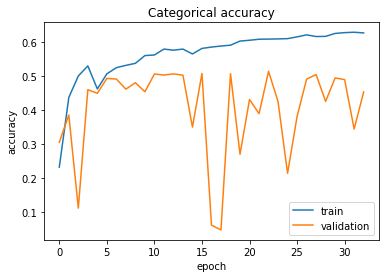

In [16]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

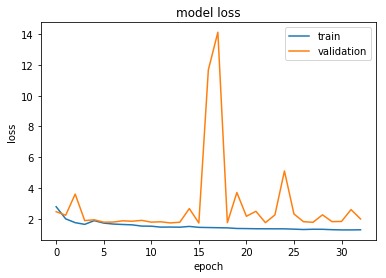

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [18]:
testEval = model.evaluate(np.reshape(test_feat, (len(test_feat), features_dim, wide, 1)), ytest, batch_size = BATCH_SIZE)

11005/11005 [==============================] - 1s 53us/step


In [19]:
print('Evaluation scores: \nMetrics: {} \nTest: {}'.format(model.metrics_names, testEval))

Evaluation scores: 
Metrics: ['loss', 'categorical_accuracy'] 
Test: [2.1447927146107433, 0.4115402089390415]


In [20]:
ROOT_DIR = os.path.normpath(os.path.join(os.path.dirname(os.path.realpath('__file__'))))
DATA_INFO = os.path.join(ROOT_DIR, 'data_asr', 'data_info')

In [21]:
test_files = pd.read_csv(os.path.join(DATA_INFO, 'testing_list.txt'), sep = ' ', header = None)[0].tolist()

In [22]:
test_lab = [os.path.dirname(i) for i in test_files]

In [23]:
lab = LabelEncoder()

test_encode = lab.fit_transform(test_lab)

In [24]:
test_encode

array([22, 22, 22, ..., 10, 10, 10])

In [25]:
y_pred = model.predict(np.reshape(test_feat, (len(test_feat), features_dim, wide, 1)), verbose=1)

11005/11005 [==============================] - 1s 77us/step


In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.figure(figsize=(25,25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), size=11,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    plt.savefig('cnn1_1k.png', dpi = 400)
    plt.tight_layout()

In [27]:
classes = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 
          'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 
          'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree',
          'two', 'up', 'visual', 'wow', 'yes', 'zero']

In [28]:
np.argmax(y_pred, 1)

array([15, 17, 21, ..., 15, 19, 18])

In [29]:
cm = confusion_matrix(test_encode, np.argmax(y_pred, 1))

Normalized confusion matrix


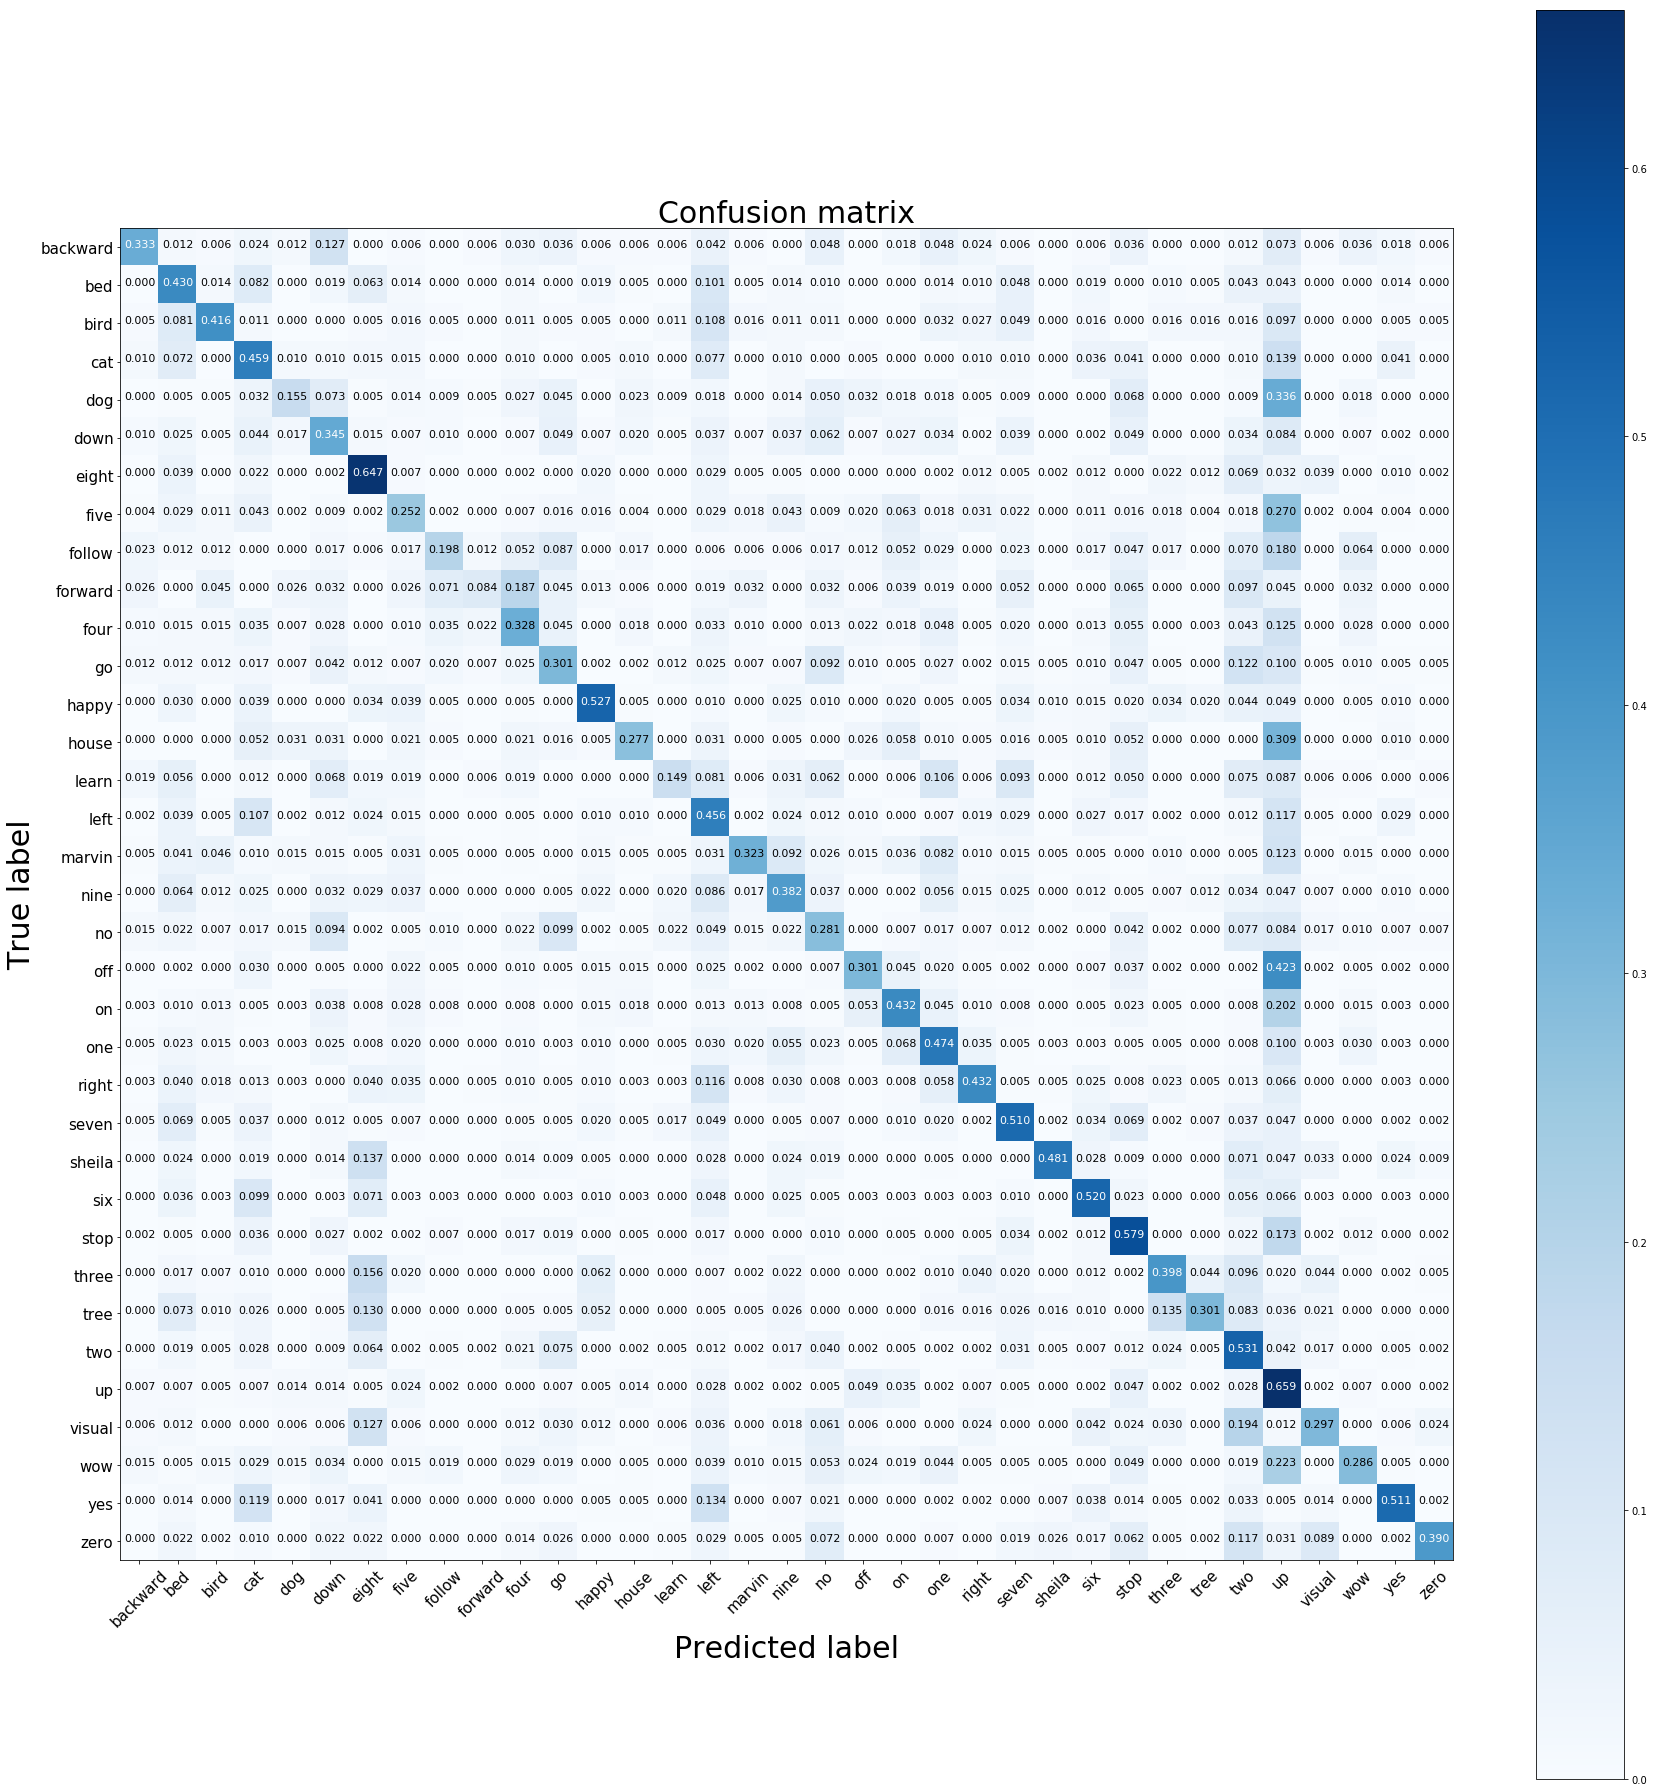

In [30]:
plot_confusion_matrix(cm, classes, normalize=True)

In [31]:
print(classification_report(test_encode, np.argmax(y_pred, 1), target_names = classes))

              precision    recall  f1-score   support

    backward       0.52      0.33      0.41       165
         bed       0.24      0.43      0.31       207
        bird       0.48      0.42      0.44       185
         cat       0.20      0.46      0.28       194
         dog       0.40      0.15      0.22       220
        down       0.37      0.34      0.36       406
       eight       0.46      0.65      0.54       408
        five       0.43      0.25      0.32       445
      follow       0.35      0.20      0.25       172
     forward       0.39      0.08      0.14       155
        four       0.48      0.33      0.39       400
          go       0.37      0.30      0.33       402
       happy       0.47      0.53      0.50       203
       house       0.44      0.28      0.34       191
       learn       0.35      0.15      0.21       161
        left       0.30      0.46      0.36       412
      marvin       0.47      0.32      0.38       195
        nine       0.46    